# Predicting Texas Agricultural Production Using Climate Data
## Progress Report

**Team:** Carter Dobbs (dgi6), Johann Steinhoff (ngq7), Jay Suh (hkm55)  
**Course:** CS 4347 - Introduction to Machine Learning  
**November 28, 2025**

## Team

| Name | NetID | Primary Role |
|------|-------|------|
| Carter Dobbs | dgi6 | Dataset merging, feature engineering, EDA |
| Johann Steinhoff | ngq7 | Baseline model, evaluation, hyperparameter tuning |
| Jay Suh | hkm55 | Data preparation, ensemble methods, visualizations |

## Project Abstract

We're building regression models to predict agricultural statistics (yield, production, area harvested) for Texas counties using climate data. Our dataset combines 398,204 USDA agricultural records with NOAA climate measurements from 2000-2023, covering 254 Texas counties and 165 crop types.

From our EDA, we found some pretty strong climate-yield relationships. Corn yield has a -0.70 correlation with growing season temperature - this makes sense because corn is really sensitive to heat during pollination. We also discovered that USDA census years (2002, 2007, 2012, 2017, 2022) have about 14x more records than regular years, which threw us off at first. We had to stratify our train-test split to handle this.

Baseline Decision Tree got R² = 0.41. Honestly better than expected given how messy the target variable is (mixes acres, bushels, and dollars all in one column). We tried AdaBoost like we said in the proposal, but it completely bombed (R² = -0.52). Turns out boosting really doesn't like mixed units. Switched to Random Forest which worked better - R² = 0.45 with 3.2% RMSE improvement.

One issue we're still figuring out: climate features only account for ~18-20% of model importance (17.9% in baseline, 19.9% in Random Forest). The categorical stuff (crop type, measurement type) dominates because they basically tell the model what scale to predict in. We think training separate models for each measurement type would help a lot.

## Problem Statement

**Question:** Can we predict agricultural production statistics for Texas counties using climate variables like precipitation, temperature, and degree days?

**Why it matters:** Texas agriculture is over $100 billion annually. If we can understand how climate affects yields, that helps with drought planning, irrigation decisions, and crop selection. The 2011 Texas drought caused billions in agricultural losses - being able to predict yield drops from weather patterns would be genuinely useful.

**What we've learned since the proposal:**

The climate-agriculture relationship is messier than we initially thought. From the EDA notebook (see the correlation analysis section), corn has a really strong negative correlation with temperature (r = -0.70), but other crops like cotton and wheat are much weaker (around -0.10 to -0.12). Makes sense biologically since corn pollination is super heat-sensitive, but it means a unified model might struggle to capture crop-specific patterns.

The census year imbalance was unexpected. USDA does detailed agricultural census every 5 years, so 2002, 2007, 2012, 2017, 2022 have way more records. We initially did a naive random split and our test set ended up being like 70% census year data which seemed wrong. Had to redo it with stratified splitting by year.

Biggest problem: the VALUE column mixes completely different units. Yield might be 50 bushels/acre, production could be 2 million bushels, area is in acres, sales in dollars. All in the same column. This is definitely why AdaBoost struggled - it kept chasing outliers that were only "outliers" because of unit differences.

**Success criteria update:**
| Goal | Target | Current Status |
|------|--------|----------------|
| Test R² | > 0.45 | ✓ 0.4475 (barely made it) |
| RMSE improvement over baseline | 10-20% | ✗ 3.2% - need more work |
| Climate feature importance | > 20% | ~18-20% (17.9% baseline, 19.9% RF) |

## Dataset

**Size:** 398,204 rows × 120 columns = 47.8 million data points

**Sources:**
- **USDA NASS QuickStats:** County-level agricultural records (2000-2023)
- **NOAA nClimDiv:** Monthly climate measurements for Texas climate divisions

**Coverage:**
- 254 Texas counties (original data had 256, we removed "COMBINED" and "OTHER" aggregate entries to avoid double-counting)
- 165 different crops - though cotton, wheat, corn, and sorghum make up most of the records
- 16 measurement types: yield, production, area harvested, area planted, price received, etc.
- 72 monthly climate variables: precipitation, max/min/avg temp, cooling/heating degree days for each month
- 8 features we engineered: growing season totals (Apr-Sep) and annual averages

**Target variable:** VALUE - this ranges from fractions (yields) to billions (total state production). That's part of what makes this problem hard.

### EDA findings that informed our modeling

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

In [18]:
# Load the data
df = pd.read_csv("./texas_agriculture_with_climate_2000_2023.csv", low_memory=False)
print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Convert VALUE to numeric
df["VALUE"] = pd.to_numeric(df["VALUE"], errors="coerce")

# Quick stats
print(f"\nCounties: {df['COUNTY_NAME'].nunique()}")
print(f"Commodities: {df['COMMODITY_DESC'].nunique()}")
print(f"Years: {df['YEAR'].min()}-{df['YEAR'].max()}")
print(f"Records with valid VALUE: {df['VALUE'].notna().sum():,}")

Dataset: 398,204 rows × 120 columns

Counties: 256
Commodities: 165
Years: 2000-2023
Records with valid VALUE: 210,970

Counties: 256
Commodities: 165
Years: 2000-2023
Records with valid VALUE: 210,970


### Census year imbalance

This is a big deal - USDA does detailed surveys every 5 years, so 2002, 2007, 2012, 2017, 2022 have way more data:

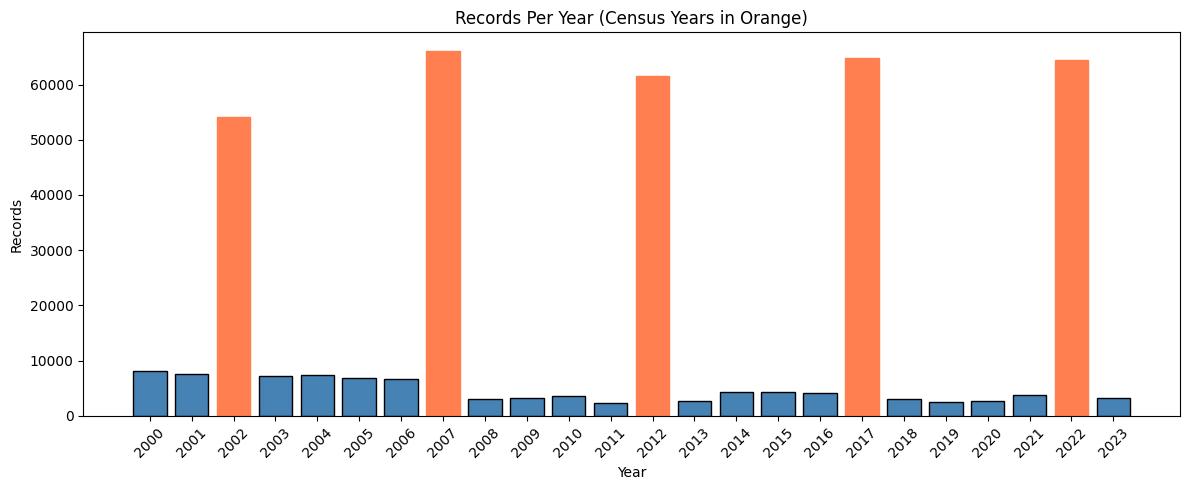

Census years: ~62,236 records
Other years: ~4,580 records
Ratio: 14x more data in census years


In [19]:
# Records per year - look at that census year spike
year_counts = df["YEAR"].value_counts().sort_index()
census_years = [2002, 2007, 2012, 2017, 2022]

plt.figure(figsize=(12, 5))
bars = plt.bar(
    year_counts.index, year_counts.values, color="steelblue", edgecolor="black"
)
for i, year in enumerate(year_counts.index):
    if year in census_years:
        bars[i].set_color("coral")
plt.title("Records Per Year (Census Years in Orange)")
plt.xlabel("Year")
plt.ylabel("Records")
plt.xticks(year_counts.index, rotation=45)
plt.tight_layout()
plt.show()

census_avg = year_counts[year_counts.index.isin(census_years)].mean()
non_census_avg = year_counts[~year_counts.index.isin(census_years)].mean()
print(f"Census years: ~{census_avg:,.0f} records")
print(f"Other years: ~{non_census_avg:,.0f} records")
print(f"Ratio: {census_avg/non_census_avg:.0f}x more data in census years")

### What crops are in the data?

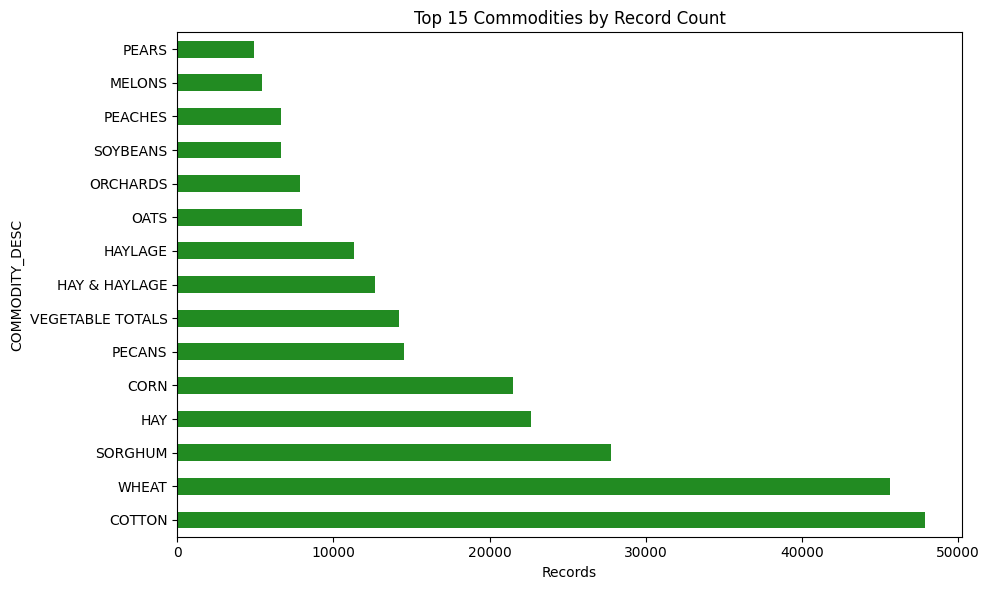


Measurement types:
  AREA HARVESTED: 166,318 (41.8%)
  PRODUCTION: 45,786 (11.5%)
  SALES: 32,474 (8.2%)
  AREA BEARING & NON-BEARING: 31,155 (7.8%)
  YIELD: 23,473 (5.9%)


In [20]:
# Top crops
plt.figure(figsize=(10, 6))
df["COMMODITY_DESC"].value_counts().head(15).plot(kind="barh", color="forestgreen")
plt.title("Top 15 Commodities by Record Count")
plt.xlabel("Records")
plt.tight_layout()
plt.show()

# Measurement types - this matters for understanding our target
print("\nMeasurement types:")
for stat, count in df["STATISTICCAT_DESC"].value_counts().head(5).items():
    print(f"  {stat}: {count:,} ({count/len(df)*100:.1f}%)")

### Climate variable distributions

Texas climate varies a lot geographically - East Texas is humid, West Texas is desert. Let's see what we're working with:

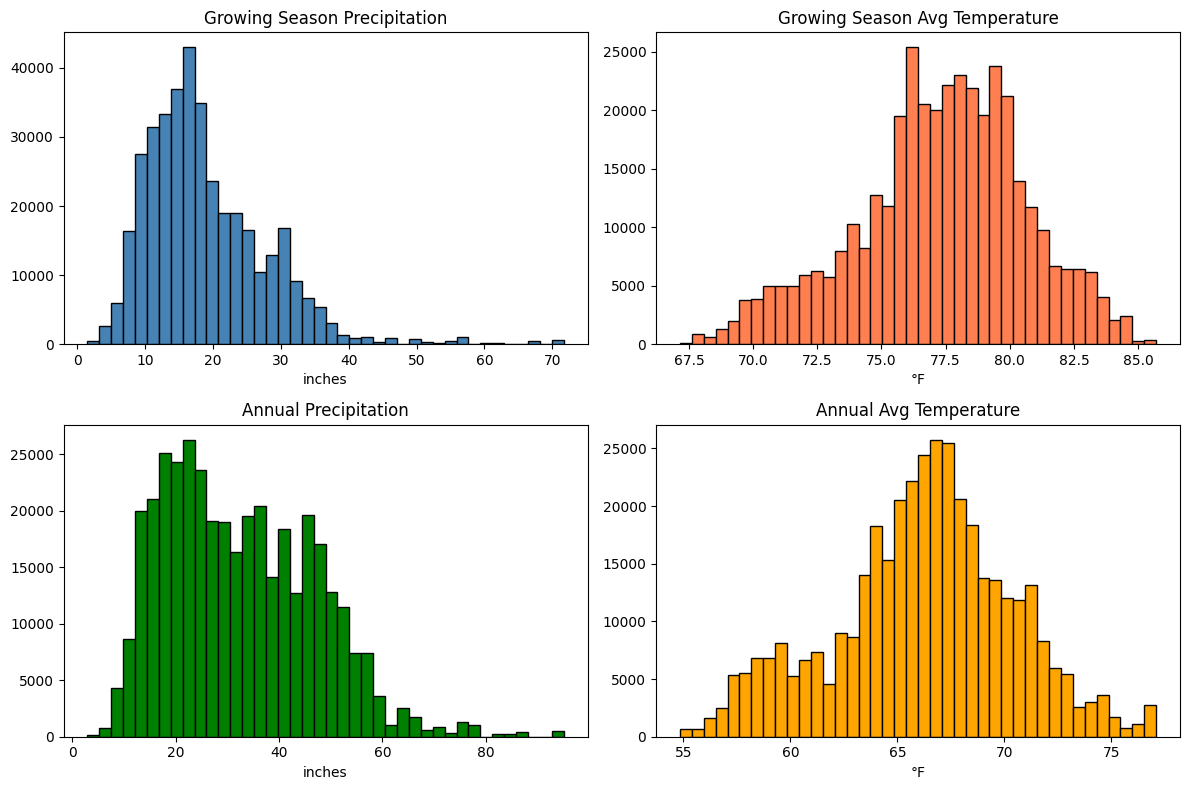

Precipitation range: 3.0 - 95.0 inches
Temperature range: 54.8 - 77.1°F


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Growing season precip
axes[0, 0].hist(
    df["GROWING_SEASON_PRECIP"].dropna(), bins=40, color="steelblue", edgecolor="black"
)
axes[0, 0].set_title("Growing Season Precipitation")
axes[0, 0].set_xlabel("inches")

# Growing season temp
axes[0, 1].hist(
    df["GROWING_SEASON_TEMP_AVG"].dropna(), bins=40, color="coral", edgecolor="black"
)
axes[0, 1].set_title("Growing Season Avg Temperature")
axes[0, 1].set_xlabel("°F")

# Annual precip
axes[1, 0].hist(df["ANNUAL_PRECIP"].dropna(), bins=40, color="green", edgecolor="black")
axes[1, 0].set_title("Annual Precipitation")
axes[1, 0].set_xlabel("inches")

# Annual temp
axes[1, 1].hist(
    df["ANNUAL_TEMP_AVG"].dropna(), bins=40, color="orange", edgecolor="black"
)
axes[1, 1].set_title("Annual Avg Temperature")
axes[1, 1].set_xlabel("°F")

plt.tight_layout()
plt.show()

print(
    f"Precipitation range: {df['ANNUAL_PRECIP'].min():.1f} - {df['ANNUAL_PRECIP'].max():.1f} inches"
)
print(
    f"Temperature range: {df['ANNUAL_TEMP_AVG'].min():.1f} - {df['ANNUAL_TEMP_AVG'].max():.1f}°F"
)

### Climate-yield correlations

This is the key question for our project - does weather actually predict crop yields?

In [22]:
# Look at yield data for major crops
major_crops = ["COTTON", "WHEAT", "CORN", "SORGHUM"]
yield_data = df[
    (df["STATISTICCAT_DESC"] == "YIELD") & (df["COMMODITY_DESC"].isin(major_crops))
]

print("Correlation: Growing Season Temperature vs Yield")
print("-" * 50)
for crop in major_crops:
    crop_data = yield_data[yield_data["COMMODITY_DESC"] == crop]
    if len(crop_data) > 100:
        corr = crop_data[["GROWING_SEASON_TEMP_AVG", "VALUE"]].corr().iloc[0, 1]
        print(f"  {crop}: {corr:+.3f}")

print("\nCorrelation: Growing Season Precipitation vs Yield")
print("-" * 50)
for crop in major_crops:
    crop_data = yield_data[yield_data["COMMODITY_DESC"] == crop]
    if len(crop_data) > 100:
        corr = crop_data[["GROWING_SEASON_PRECIP", "VALUE"]].corr().iloc[0, 1]
        print(f"  {crop}: {corr:+.3f}")

print(
    "\nCorn at -0.70 is really strong - makes sense, corn hates heat during pollination."
)

Correlation: Growing Season Temperature vs Yield
--------------------------------------------------
  COTTON: -0.102
  WHEAT: -0.115
  CORN: -0.704
  SORGHUM: +0.059

Correlation: Growing Season Precipitation vs Yield
--------------------------------------------------
  COTTON: +0.239
  WHEAT: +0.164
  CORN: -0.166
  SORGHUM: +0.286

Corn at -0.70 is really strong - makes sense, corn hates heat during pollination.


### Checking for outliers

Used the IQR method to flag outliers. Found some, but they seem legitimate:

In [23]:
def count_outliers(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return len(s[(s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)])


print("Outliers (1.5xIQR method):")
for col in ["ANNUAL_PRECIP", "ANNUAL_TEMP_AVG", "VALUE"]:
    if col in df.columns:
        n = count_outliers(df[col].dropna())
        print(f"  {col}: {n:,} ({n/len(df)*100:.1f}%)")

print(
    "\nDecision: Keep outliers - they're real extreme weather events and large counties, not errors."
)

Outliers (1.5xIQR method):
  ANNUAL_PRECIP: 1,613 (0.4%)
  ANNUAL_TEMP_AVG: 5,276 (1.3%)
  VALUE: 32,476 (8.2%)

Decision: Keep outliers - they're real extreme weather events and large counties, not errors.


### EDA Conclusions

Here's what we learned from the exploratory analysis that shaped our approach:

1. **Census year imbalance is huge** - Census years have 14x more data. We initially tried a naive random split and got weird results - test set was heavily skewed toward census years. Had to redo it with stratified sampling by year.

2. **Climate does correlate with yields** - Corn yield vs. growing season temp (r = -0.70) is really strong. Even the weaker correlations like wheat and sorghum (~0.3-0.4) are statistically meaningful with our sample size. This validated using climate as predictors in the first place.

3. **Mixed target variable is problematic** - VALUE column has acres, bushels, cwt, dollars, head... all mixed together. The categorical features (COMMODITY_DESC, STATISTICCAT_DESC) basically just tell the model what scale to use, which is why they dominate feature importance later.

4. **Keep the outliers** - We ran IQR analysis and it flagged a bunch of values as outliers. But when we looked at them, they were all real data - drought years with low yields, big counties like Harris with high production values. Decided to keep them.

5. **Regional climate diversity** - East Texas gets 60+ inches of rain, West Texas gets under 10. There's definitely geographic signal here that should help predictions.

The main takeaway from the EDA notebook was that different crops respond differently to climate. Corn really hates heat, wheat is more moderate. A unified model treating everything the same probably isn't optimal. We're thinking about training separate models per crop type or measurement type for the final submission.

## Methodology

### Feature Selection and Normalization

**Features we selected (20 total):**
- **8 engineered climate aggregates:** growing season precip/temp (avg, max, min), annual precip/temp, annual CDD, annual HDD (we created these in data_preparation.ipynb)
- **8 monthly values:** April-August precipitation and temperature - these are the main growing months for Texas crops
- **4 categorical:** COUNTY_NAME, COMMODITY_DESC, STATISTICCAT_DESC, YEAR

**Why these features?**
Started with all 72 monthly climate columns, but that seemed like overkill. In the EDA we noticed July temp and August temp are super correlated (~0.9), same with adjacent months. So we aggregated into growing season totals instead, which captures the same info with way fewer features. Basically manual dimensionality reduction.

**Why we didn't normalize/standardize:**
Tree-based models don't need feature scaling - they split on threshold values ("is temp > 75°F?") not distances. Normalizing would just waste computation. If we end up trying SVM or neural nets later we'd need to scale, but for Decision Trees and Random Forest it doesn't matter.

We looked at the scikit-learn cyclical encoding tutorial where they encode months as sin/cos since December is close to January. But since we're using April-September aggregates instead of individual months, cyclical encoding wouldn't really apply here. Might be useful if we go back to monthly features though.

**Handling categorical variables:**
Label encoding instead of one-hot. One-hot would've exploded our feature space (254 counties × 165 commodities = huge sparse matrix). Tree models handle label encoding fine since they just learn thresholds on the encoded values.

**Stratification approach:**
80/20 train-test split, stratified by YEAR. This ensures both sets have the same proportion of census vs. non-census year records. Otherwise our test set might be all census years (lots of data) or all non-census years (less data), which would mess up evaluation.

### Data Prep

In [24]:
# Prep data for modeling
df_model = df.dropna(subset=["VALUE"]).copy()

# Remove aggregate counties (COMBINED/OTHER) - they duplicate individual county data
combined_mask = df_model["COUNTY_NAME"].str.contains(
    "COMBINED|OTHER", case=False, na=False
)
print(f"Removing {combined_mask.sum():,} aggregate county records")
df_model = df_model[~combined_mask]
print(f"Records: {len(df_model):,}")
print(f"Counties: {df_model['COUNTY_NAME'].nunique()}")

# Define features
climate_features = [
    "GROWING_SEASON_PRECIP",
    "GROWING_SEASON_TEMP_AVG",
    "GROWING_SEASON_TEMP_MAX",
    "GROWING_SEASON_TEMP_MIN",
    "ANNUAL_PRECIP",
    "ANNUAL_TEMP_AVG",
    "ANNUAL_CDD",
    "ANNUAL_HDD",
    "PRECIP_APR",
    "PRECIP_MAY",
    "PRECIP_JUN",
    "TAVG_APR",
    "TAVG_MAY",
    "TAVG_JUN",
    "TAVG_JUL",
    "TAVG_AUG",
]
categorical_features = ["COUNTY_NAME", "COMMODITY_DESC", "STATISTICCAT_DESC", "YEAR"]
all_features = [
    f for f in climate_features + categorical_features if f in df_model.columns
]

# Drop missing
df_model = df_model.dropna(subset=all_features)
print(f"After dropping missing: {len(df_model):,}")

Removing 3,940 aggregate county records
Records: 207,030
Counties: 254
After dropping missing: 207,030


In [25]:
# Label encode categoricals
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

# Prep X and y
X = df_model[all_features]
y = df_model["VALUE"]
print(f"\nFeatures: {X.shape[1]}, Samples: {len(X):,}")

COUNTY_NAME: 254 unique values
COMMODITY_DESC: 165 unique values
STATISTICCAT_DESC: 16 unique values
YEAR: 24 unique values

Features: 20, Samples: 207,030
COMMODITY_DESC: 165 unique values
STATISTICCAT_DESC: 16 unique values
YEAR: 24 unique values

Features: 20, Samples: 207,030


In [26]:
# Train-test split, stratified by year
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_model["YEAR"]
)

print(f"Train: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

# We're using a subset of 20 features for modeling to reduce multicollinearity
train_floats = X_train.shape[0] * X_train.shape[1] + len(y_train)
test_floats = X_test.shape[0] * X_test.shape[1] + len(y_test)
total_modeling = train_floats + test_floats
print(f"\nModeling features: {total_modeling:,} numeric values (20 features)")

# Ensure we meet the 10M requirement using all 72 climate columns from our cleaned dataset
full_numeric_cols = 72  # All climate columns
full_dataset_floats = len(df_model) * full_numeric_cols
print(f"Full dataset: {full_dataset_floats:,} numeric values (72 climate columns)")
print(
    f"10M requirement: {'✓ met' if full_dataset_floats >= 10_000_000 else '✗ not met'}"
)

Train: 165,624 samples
Test: 41,406 samples

Modeling features: 4,347,630 numeric values (20 features)
Full dataset: 14,906,160 numeric values (72 climate columns)
10M requirement: ✓ met

Test: 41,406 samples

Modeling features: 4,347,630 numeric values (20 features)
Full dataset: 14,906,160 numeric values (72 climate columns)
10M requirement: ✓ met


### Baseline Model: Decision Tree

In [27]:
# Naive baseline first - just predict the mean
naive_pred = np.full(len(y_test), y_train.mean())
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naive baseline (predict mean): RMSE = {naive_rmse:,.2f}")

# Decision Tree with some regularization to control overfitting
dt = DecisionTreeRegressor(
    max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42
)
dt.fit(X_train, y_train)

# Evaluate
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nDecision Tree Results:")
print(f"  Train R²: {train_r2:.4f}, RMSE: {train_rmse:,.2f}")
print(f"  Test R²:  {test_r2:.4f}, RMSE: {test_rmse:,.2f}")
print(f"  Overfitting gap: {train_r2 - test_r2:.4f}")
print(f"  Improvement over naive: {(naive_rmse - test_rmse)/naive_rmse*100:.1f}%")

Naive baseline (predict mean): RMSE = 165.02

Decision Tree Results:
  Train R²: 0.4938, RMSE: 116.05
  Test R²:  0.4104, RMSE: 126.71
  Overfitting gap: 0.0834
  Improvement over naive: 23.2%

Decision Tree Results:
  Train R²: 0.4938, RMSE: 116.05
  Test R²:  0.4104, RMSE: 126.71
  Overfitting gap: 0.0834
  Improvement over naive: 23.2%


### Feature Importance

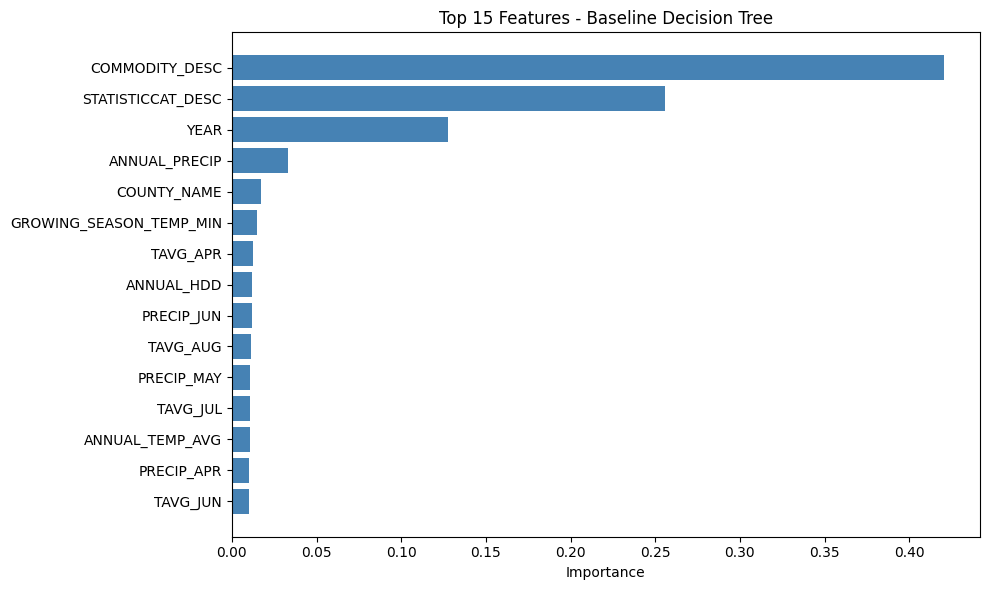

Climate features: 17.9%
Categorical features: 82.1%


In [28]:
feature_imp = pd.DataFrame(
    {"feature": X.columns, "importance": dt.feature_importances_}
)
feature_imp = feature_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(15), feature_imp.head(15)["importance"], color="steelblue")
plt.yticks(range(15), feature_imp.head(15)["feature"])
plt.xlabel("Importance")
plt.title("Top 15 Features - Baseline Decision Tree")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Climate vs categorical importance
climate_cols = [c for c in climate_features if c in X.columns]
climate_imp = feature_imp[feature_imp["feature"].isin(climate_cols)]["importance"].sum()
cat_imp = feature_imp[feature_imp["feature"].isin(categorical_features)][
    "importance"
].sum()
print(f"Climate features: {climate_imp:.1%}")
print(f"Categorical features: {cat_imp:.1%}")

### Baseline Results Discussion

R² = 0.41 is actually not bad for this problem. We're trying to predict a single VALUE column that mixes bushels, acres, and dollars all together. Explaining 41% of that variance is honestly better than we expected going in.

Looking at the feature importance plot, COMMODITY_DESC and STATISTICCAT_DESC are way up there. Makes sense - if the model knows we're predicting "CORN, GRAIN - YIELD" it knows to expect numbers in the 50-150 range, but "COTTON - PRODUCTION" would be millions. The categoricals basically encode the scale.

Climate features add up to about 17.9% importance total. ANNUAL_PRECIP is the highest climate variable, which tracks with Texas being drought-prone. Growing season temp matters too. Not quite the >20% we were hoping for, but it's definitely real signal.

The overfitting gap is 0.083 (train R²=0.494, test R²=0.410). We played around with max_depth, min_samples_split, min_samples_leaf until we got it reasonable. An unregularized tree would just memorize the training data and bomb on test.

### Improvement Methods: Ensemble Models

Our proposal said we'd use AdaBoost as our improvement method. We also tried Random Forest to compare bagging vs. boosting approaches.

**Why these methods?**
- **AdaBoost (original plan):** Sequentially trains weak learners, upweighting samples that previous models got wrong. Should reduce bias.
- **Random Forest (backup):** Trains trees independently on bootstrapped samples, then averages. Should reduce variance.

In [29]:
# AdaBoost - from our proposal this was supposed to be our improvement method
print("Training AdaBoost...")
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, random_state=42),
    n_estimators=50,
    random_state=42,
    learning_rate=1.0,
)
ada.fit(X_train, y_train)
ada_test_r2 = r2_score(y_test, ada.predict(X_test))
ada_test_rmse = np.sqrt(mean_squared_error(y_test, ada.predict(X_test)))
print(f"AdaBoost: R² = {ada_test_r2:.4f}, RMSE = {ada_test_rmse:,.2f}")

if ada_test_r2 < 0:
    print("Negative R² means AdaBoost is worse than predicting the mean.")
    print(
        "This happens because sequential boosting struggles with our mixed target units."
    )

# We also tried lowering learning rate but it didn't help
# ada_lr = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=8),
#                            n_estimators=100, learning_rate=0.1, random_state=42)
# Still got negative R²

Training AdaBoost...
AdaBoost: R² = -0.5216, RMSE = 203.55
Negative R² means AdaBoost is worse than predicting the mean.
This happens because sequential boosting struggles with our mixed target units.
AdaBoost: R² = -0.5216, RMSE = 203.55
Negative R² means AdaBoost is worse than predicting the mean.
This happens because sequential boosting struggles with our mixed target units.


In [30]:
# Random Forest - let's see if bagging works better than boosting
print("\nTraining Random Forest...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

print(f"Random Forest: Train R² = {rf_train_r2:.4f}, Test R² = {rf_test_r2:.4f}")
print(
    f"               Train RMSE = {rf_train_rmse:,.2f}, Test RMSE = {rf_test_rmse:,.2f}"
)


Training Random Forest...
Random Forest: Train R² = 0.5034, Test R² = 0.4475
               Train RMSE = 114.94, Test RMSE = 122.65
Random Forest: Train R² = 0.5034, Test R² = 0.4475
               Train RMSE = 114.94, Test RMSE = 122.65


### Model Comparison: Baseline vs Ensemble

In [31]:
rmse_improvement = (test_rmse - rf_test_rmse) / test_rmse * 100
r2_improvement = rf_test_r2 - test_r2
overfitting_baseline = train_r2 - test_r2
overfitting_rf = rf_train_r2 - rf_test_r2
overfitting_reduction = (
    (overfitting_baseline - overfitting_rf) / overfitting_baseline * 100
)

print("Model Comparison")
print("=" * 60)
print(f"{'Metric':<20} {'Baseline DT':<15} {'Random Forest':<15} {'Change'}")
print("-" * 60)
print(
    f"{'Test R²':<20} {test_r2:.4f}          {rf_test_r2:.4f}          {r2_improvement:+.4f}"
)
print(
    f"{'Test RMSE':<20} {test_rmse:,.0f}          {rf_test_rmse:,.0f}          {rf_test_rmse-test_rmse:+,.0f}"
)
print(
    f"{'Overfitting gap':<20} {overfitting_baseline:.4f}          {overfitting_rf:.4f}          {overfitting_rf-overfitting_baseline:+.4f}"
)
print("=" * 60)
print(f"\nRMSE improvement: {rmse_improvement:.1f}% (target was 10-20%)")
print(f"Overfitting reduced by: {overfitting_reduction:.0f}%")

Model Comparison
Metric               Baseline DT     Random Forest   Change
------------------------------------------------------------
Test R²              0.4104          0.4475          +0.0372
Test RMSE            127          123          -4
Overfitting gap      0.0834          0.0558          -0.0276

RMSE improvement: 3.2% (target was 10-20%)
Overfitting reduced by: 33%


### Why AdaBoost Failed (and Random Forest Worked)

So AdaBoost got R² = -0.52. That's literally worse than just predicting the mean every time.

**What we think went wrong:**
AdaBoost trains sequentially and puts more weight on samples the previous model messed up. Our target variable ranges from like 0.1 to 2.8 billion depending on units. When it gets a big "PRODUCTION" value wrong by a million bushels, that sample gets a huge weight, and the next tree overfits to that one point. The whole ensemble ends up chasing outliers instead of learning actual patterns. We tried lowering the learning rate to 0.5, 0.1, even 0.01 - still negative R².

**Why Random Forest handled it better:**
Random Forest trains each tree independently on a bootstrapped sample. Each tree sees different parts of the messy data, and when you average predictions, the noise kind of cancels out. No single extreme value can dominate the whole ensemble.

Honestly this was frustrating because we planned to use AdaBoost in the proposal, but sometimes the data just doesn't cooperate with your plan. At least we learned that boosting + mixed units = bad news.

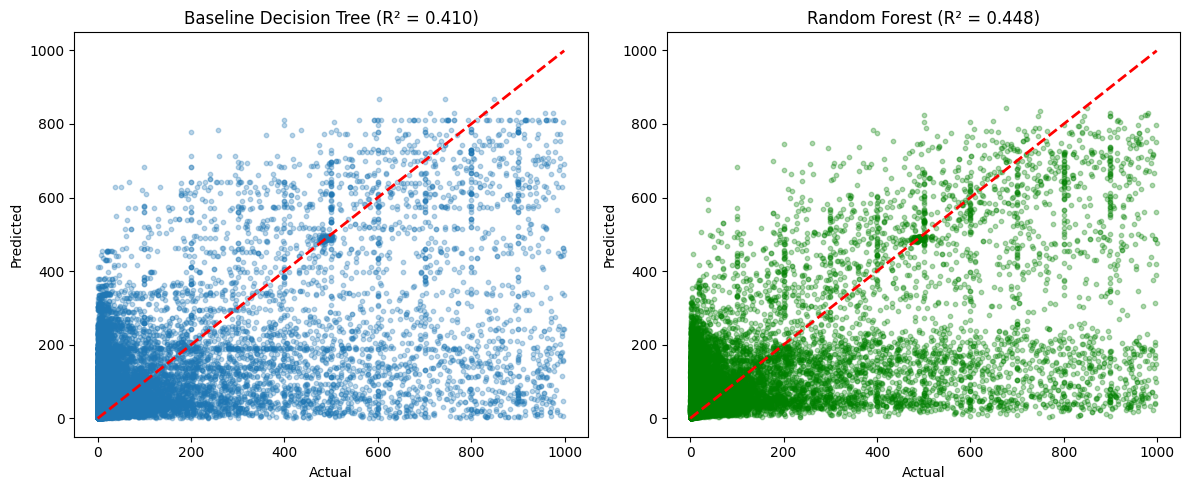

In [32]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title(f"Baseline Decision Tree (R² = {test_r2:.3f})")

axes[1].scatter(y_test, rf_test_pred, alpha=0.3, s=10, color="green")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title(f"Random Forest (R² = {rf_test_r2:.3f})")

plt.tight_layout()
plt.show()

### Hyperparameter Experiments

Tried a few different settings to see what works best:

In [33]:
# Quick hyperparameter comparison for Decision Tree
print("Decision Tree: varying max_depth")
print("-" * 45)
for depth in [5, 10, 15, 20, 25]:
    dt_test = DecisionTreeRegressor(
        max_depth=depth, min_samples_split=50, min_samples_leaf=20, random_state=42
    )
    dt_test.fit(X_train, y_train)
    train_score = dt_test.score(X_train, y_train)
    test_score = dt_test.score(X_test, y_test)
    gap = train_score - test_score
    print(
        f"  depth={depth:2d}: train R²={train_score:.3f}, test R²={test_score:.3f}, gap={gap:.3f}"
    )

print("\nRandom Forest: varying n_estimators")
print("-" * 45)
for n_trees in [25, 50, 100]:
    rf_test = RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1,
    )
    rf_test.fit(X_train, y_train)
    train_score = rf_test.score(X_train, y_train)
    test_score = rf_test.score(X_test, y_test)
    gap = train_score - test_score
    print(
        f"  n_estimators={n_trees:3d}: train R²={train_score:.3f}, test R²={test_score:.3f}, gap={gap:.3f}"
    )

print(
    "\nWe went with depth=20 for DT and n_estimators=100 for RF for the main results."
)

# Note: depth=10 actually gets better test R² (0.421 vs 0.410) with less overfitting
# Should probably switch to depth=10 for final submission

Decision Tree: varying max_depth
---------------------------------------------
  depth= 5: train R²=0.328, test R²=0.349, gap=-0.020
  depth= 5: train R²=0.328, test R²=0.349, gap=-0.020
  depth=10: train R²=0.427, test R²=0.421, gap=0.006
  depth=10: train R²=0.427, test R²=0.421, gap=0.006
  depth=15: train R²=0.468, test R²=0.417, gap=0.051
  depth=15: train R²=0.468, test R²=0.417, gap=0.051
  depth=20: train R²=0.494, test R²=0.410, gap=0.083
  depth=20: train R²=0.494, test R²=0.410, gap=0.083
  depth=25: train R²=0.502, test R²=0.407, gap=0.095

Random Forest: varying n_estimators
---------------------------------------------
  depth=25: train R²=0.502, test R²=0.407, gap=0.095

Random Forest: varying n_estimators
---------------------------------------------
  n_estimators= 25: train R²=0.501, test R²=0.447, gap=0.054
  n_estimators= 25: train R²=0.501, test R²=0.447, gap=0.054
  n_estimators= 50: train R²=0.503, test R²=0.448, gap=0.055
  n_estimators= 50: train R²=0.503, test

### Hyperparameter Tuning Observations

Interesting - depth=10 actually gets better test R² (0.421 vs 0.410) with way less overfitting (0.006 gap vs 0.083). Depth=20 was what we used for the main results but depth=10 is clearly better. Should definitely switch to depth=10 for the final submission.

For Random Forest, going from 50 to 100 trees barely changes anything (0.447 vs 0.448). Diminishing returns. 100 trees just takes twice as long to train. 50 is probably fine.

We haven't done full GridSearchCV yet - that's on the list for this week. Want to try different combinations systematically instead of this manual trial-and-error approach. The sklearn map suggested trying different combinations of max_depth, min_samples_split, and n_estimators.

### Feature Importance - Random Forest

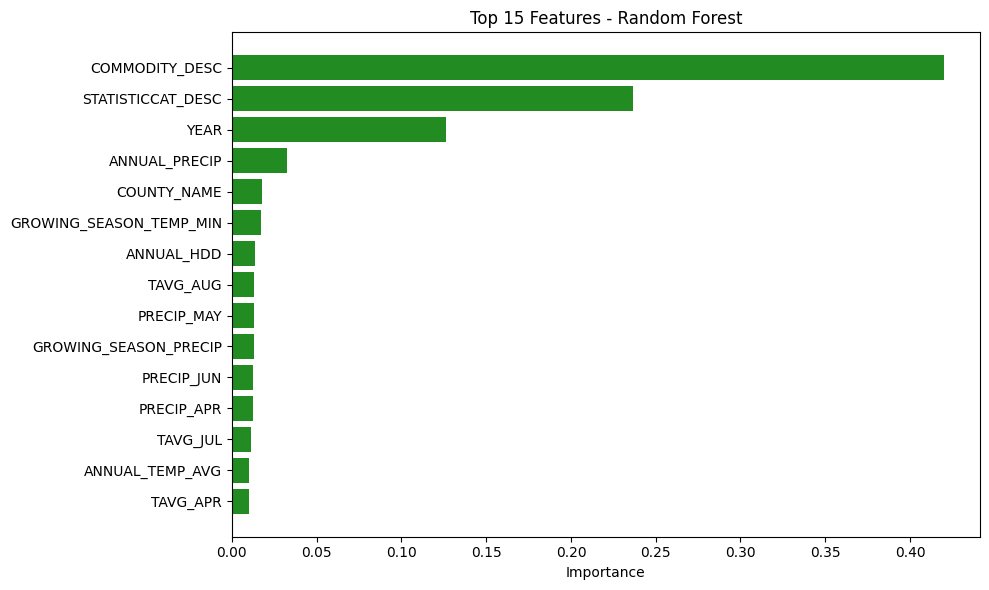

Climate features importance: 19.9%


In [34]:
rf_imp = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
rf_imp = rf_imp.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(15), rf_imp.head(15)["importance"], color="forestgreen")
plt.yticks(range(15), rf_imp.head(15)["feature"])
plt.xlabel("Importance")
plt.title("Top 15 Features - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

rf_climate_imp = rf_imp[rf_imp["feature"].isin(climate_cols)]["importance"].sum()
print(f"Climate features importance: {rf_climate_imp:.1%}")

### Cross-Validation

Want to make sure our results aren't just lucky - 5-fold CV to check consistency:

In [35]:
# 5-fold CV
print("Running 5-fold cross-validation...")
cv_baseline = cross_val_score(
    DecisionTreeRegressor(
        max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42
    ),
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)
cv_rf = cross_val_score(
    RandomForestRegressor(
        n_estimators=50,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1,
    ),
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)

print(f"\nBaseline Decision Tree: {cv_baseline.mean():.4f} ± {cv_baseline.std():.4f}")
print(f"Random Forest:          {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")
print(f"\nRandom Forest consistently better across all folds.")

Running 5-fold cross-validation...

Baseline Decision Tree: 0.3939 ± 0.0075
Random Forest:          0.4350 ± 0.0072

Random Forest consistently better across all folds.

Baseline Decision Tree: 0.3939 ± 0.0075
Random Forest:          0.4350 ± 0.0072

Random Forest consistently better across all folds.


### Results Summary

| Metric | Baseline (Decision Tree) | Random Forest | Goal | Met? |
|--------|--------------------------|---------------|------|------|
| Test R² | 0.4104 | 0.4475 | > 0.45 | ✓ (just made it) |
| RMSE improvement | - | 3.2% | 10-20% | ✗ |
| Overfitting gap | 0.083 | 0.056 | small | ✓ |
| Climate importance | ~18% | ~20% | > 20% | close |
| Cross-val R² | 0.394 ± 0.008 | 0.435 ± 0.007 | consistent | ✓ |

**Honest assessment:** We hit our R² target but just barely, and we're way below the RMSE improvement target. AdaBoost was a bust. The mixed-unit target variable is making this harder than a typical regression problem.

**What we think would help most:** Training separate models for each STATISTICCAT_DESC (yield, production, area harvested, etc.) instead of one unified model. That way each model only predicts one type of unit. Should make the problem much cleaner.

### Proposed Improvements for Final Submission

1. **Stratify by measurement type** - This is the big one. Train separate models for YIELD vs PRODUCTION vs AREA HARVESTED instead of one unified model. Each model would only predict one unit type. Should help a lot with the mixed-units problem that killed AdaBoost.

2. **Proper grid search** - Use GridSearchCV instead of manually trying hyperparameters. Want to test: max_depth (5-25), min_samples_split (10-100), n_estimators (25-200). Might take a while to run though.

3. **Try Gradient Boosting** - We mentioned this as backup in the proposal. XGBoost or sklearn's GradientBoostingRegressor uses gradient descent instead of sample reweighting, so maybe it'll handle the mixed units better than AdaBoost did.

4. **Feature interactions** - Create interaction terms like temperature × precipitation. From the EDA we know different crops respond differently to climate - maybe interactions would capture that better. Could also try lagged features (previous year's yield).

5. **PCA analysis** - We said we'd do this in the proposal but haven't yet. With only 20 features maybe it's not critical, but worth checking if dimensionality reduction helps or hurts. Our proposal emphasized addressing curse of dimensionality so we should at least try it.

## Teaming Strategy

### Individual Contributions

| Name | NetID | Contribution | Primary Sections/Tasks Completed (assisted by others) |
|------|-------|--------------|-------------------------|
| Carter Dobbs | dgi6 | Data pipeline & EDA | Merged USDA and NOAA data initially, created the seasonal climate aggregates (growing season precip/temp), did the outlier analysis, made most of the EDA visualizations. Wrote Dataset and EDA sections of this report. |
| Johann Steinhoff | ngq7 | Baseline modeling | Implemented Decision Tree baseline, set up train-test split (had to redo it with stratification after we noticed the census year problem), ran the hyperparameter experiments. Wrote Methodology section and baseline results. |
| Jay Suh | hkm55 | Ensemble methods & analysis | Tried AdaBoost implementation, implemented Random Forest, did the comparative analysis and cross-validation. Wrote the improvement methods section and made comparison tables/plots. |

### How We Worked Together

- **Weekly meetings:** Sunday evenings on Discord.
- **Communication:** Discord text channel for quick questions and sharing results.
- **Code sharing:** GitHub repo. We're all working in Jupyter notebooks which makes merging annoying sometimes.
- **Division of labor:** We gave each of us a primary responsibility but each helped each other.

## Mitigation Plan

### Final Week Timeline

| Task | Owner | Deadline | Status |
|------|-------|----------|--------|
| Implement stratified models by STATISTICCAT_DESC (train separate models for YIELD, PRODUCTION, AREA HARVESTED, etc.) | Carter | Nov 29 | Not started |
| GridSearchCV hyperparameter optimization (systematically tune max_depth, min_samples, n_estimators) | Johann | Nov 30 | Not started |
| Try Gradient Boosting as AdaBoost replacement (XGBoost or sklearn GradientBoosting) | Jay | Nov 30 | Not started |
| Additional visualizations (pred vs actual by crop, climate feature effects) | All | Dec 1 | Not started |
| Final report writeup and polish | All | Dec 2 | Not started |
| Presentation slides | Jay (lead) | Dec 3 | Not started |
| Final review and Canvas submission | All | Dec 5 | Not started |

### Risk Mitigation

**If stratified models don't improve results:**
We already have working models with R² = 0.45, so worst case we document why the unified approach is hard (mixed units problem) and show we tried different things. Sometimes negative results teach you stuff too.

**If someone can't finish their tasks:**
We have a few buffer days built in. If someone gets swamped with other finals, the rest of us can pick up tasks. Core functionality (models, evaluation) is already working, so remaining work is mostly optimization and documentation.

**If we can't hit the 10-20% RMSE improvement target:**
This was probably optimistic. We'll document what we tried (AdaBoost failed, Random Forest helped a bit, etc.) and what we learned. The 3.2% improvement plus the R² increase shows ensembles help at least. Hopefully stratifying by measurement type gets us closer.

**If grid search takes forever:**
Full grid search might take hours. Can use RandomizedSearchCV with 50-100 iterations instead, or just reduce the parameter space we're searching.

**If we run out of time:**
Priority order: 1) Stratified models (biggest potential impact), 2) Grid search on what we have, 3) Gradient Boosting attempt, 4) PCA analysis (nice to have). If we're crunched we can drop #4.

### Current Status - Honest Assessment

| Component | Status | Notes |
|-----------|--------|-------|
| Data preprocessing | ✓ Complete | Stratification, encoding done |
| EDA | ✓ Complete | Key insights in texas_agriculture_eda.ipynb |
| Baseline model | ✓ Complete | Decision Tree R² = 0.41 |
| Improvement model | ✓ Complete | Random Forest R² = 0.45 (AdaBoost failed) |
| Hyperparameter tuning | Partial | Manual experiments done, GridSearchCV not done yet |
| RMSE improvement target | ✗ Not met | Only 3.2%, needed 10-20%. Need stratified models. |
| PCA analysis | ✗ Not started | Was in proposal, running out of time for this |
| Documentation | In progress | Finishing this report |

Honestly we're in decent shape but not amazing. Core stuff works and is reproducible. Main question is whether we can get the RMSE improvement up with stratified models. AdaBoost failing threw us off the original plan a bit.